In [24]:
import sys 
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')
sys.path.append('/pl/active/banich/studies/Clearvale/jake_scripts/Amy_flywheel_scripts/')

import numpy as np
import pandas as pd
import os

In [2]:
z_data = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/ClearMem_Z_Average.csv')
z_data = z_data[['SubID', 'z_ave', 'PSWQ_total', 'WBSI_total', 'RRS_total', 'RRS_depression', 'RRS_brooding', 'RRS_reflection']]
z_data = z_data.dropna()

from scipy.stats import zscore
z_data['br_z_ave'] = z_data['z_ave']
z_data.drop('z_ave', axis=1, inplace=True)
z_data['b_z_ave'] = (zscore(z_data['PSWQ_total']) + zscore(z_data['WBSI_total']) + zscore(z_data['RRS_brooding']))/3
z_data['thought_problems'] = (zscore(z_data['PSWQ_total']) + zscore(z_data['WBSI_total']) + zscore(z_data['RRS_brooding']) + zscore(z_data['RRS_reflection']) + zscore(z_data['RRS_depression']))/5

z_data = z_data.drop(['PSWQ_total', 'WBSI_total','RRS_total', 'RRS_depression', 
                     'RRS_brooding', 'RRS_reflection', 'br_z_ave'], axis=1)


In [4]:
classifiers = (pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_classifiers.csv')
               .drop('Unnamed: 0', axis=1).filter(regex='Sub|acc'))

eccentricity = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_eccentricity.csv')

across_network_disp = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_across_network_dispersion.csv').drop('Unnamed: 0', axis=1)

modularity = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_network_modularity.csv').drop('Unnamed: 0', axis=1)
op_modularity = modularity.iloc[:, :5]
network_modularity = modularity.drop(op_modularity.iloc[:, 1:].columns, axis=1)

eigcent = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_network_eigcent.csv')

within_network_disp = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_within_network_dispersion.csv')

grad_ranges = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_gradient_range.csv')
grad_ranges = grad_ranges[['SubID', 'suppress_g3', 'clear_g3']]

In [23]:
all_op_metrics_z = pd.merge(within_network_disp, eccentricity, on='SubID').filter(regex='SubID|disp|ecc')
all_op_metrics_z.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/regressions/data/rsa/dispersion_metrics_z.csv', index=False)

In [5]:
all_op_metrics = pd.merge(classifiers, eccentricity, on='SubID')
all_op_metrics = pd.merge(across_network_disp, all_op_metrics, on='SubID')
all_op_metrics = pd.merge(modularity, all_op_metrics, on='SubID')
all_op_metrics = pd.merge(eigcent, all_op_metrics, on='SubID')
all_op_metrics = pd.merge(within_network_disp, all_op_metrics, on='SubID')
all_op_metrics = pd.merge(grad_ranges, all_op_metrics, on='SubID')

all_op_metrics_z = pd.merge(all_op_metrics, z_data, on='SubID')

In [8]:
#all_op_metrics_z.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/bootstrapped_regressions/data/rsa/dispersion_metrics_z.csv', index=False)

In [10]:
import sys 

sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')
sys.path.append('/pl/active/banich/studies/Clearvale/jake_scripts/Amy_flywheel_scripts/')

import sys 
import os
import glob
import numpy as np
import scipy.io
import pandas as pd

def run_regression(data, target, y_var, interaction=None):
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    
    if interaction is not None:
        # Creating the formula with interaction terms if specified
        formula = f'{target[0]} ~ {y_var} * {interaction}'
    else:
        formula = f'{target[0]} ~ {y_var}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Print the full regression output
    summary = model.summary()

    var = pd.DataFrame(summary.tables[0].data).iloc[0, 1]

    table1 = pd.DataFrame(summary.tables[0].data).iloc[:4, 3:].T.assign(var=var)
    table1.columns = ['r2', 'adjr2', 'fstat', 'pval', 'var']
    table1 = table1[['var', 'r2', 'adjr2', 'fstat', 'pval']]

    table2_cols = pd.DataFrame(summary.tables[1].data).loc[0].to_list() + ['var']
    table2_cols[0] = 'parameter'
    table2 = pd.DataFrame(summary.tables[1].data).iloc[1:].assign(var=var)
    table2.columns = table2_cols
    table2 = table2[['var', 'parameter', 'coef', 'std err', 't', 'P>|t|']]

    df = pd.merge(table1, table2, how='outer', left_on='var', right_on='parameter')

    # Combine 'var_x' and 'var_y' into a new column 'var'
    df['var'] = df['var_x'].fillna(df['var_y'])

    # Drop the original 'var_x' and 'var_y' columns
    df.drop(columns=['var_x', 'var_y'], inplace=True)

    # Reorder columns to place 'var' at the front
    cols = ['var'] + [col for col in df.columns if col != 'var']
    df = df[cols]
    df = df.assign(formula=formula)

    return df


def regression_function(data, variable_list, interaction):
    import pandas as pd

    targets = [['thought_problems'], ['b_z_ave']]

    regression_results = []
    for target in targets:
        for variable in variable_list:
            regression_results.append(run_regression(data, target, variable, interaction))

    output_regressions = pd.concat(regression_results)

    # List of columns to convert
    columns_to_convert = ['r2', 'adjr2', 'fstat', 'pval', 'coef', 'std err', 't', 'P>|t|']

    # Convert each specified column to numeric, handling non-numeric values by converting them to NaN
    for column in columns_to_convert:
        output_regressions[column] = pd.to_numeric(output_regressions[column], errors='coerce')

    return output_regressions#[['var', 'r2', 'adjr2', 'fstat', 'pval', 'formula']]

In [11]:
def run_regs(data, test_cols, method):
    
    regression_output = regression_function(data, test_cols, interaction=None)
    regression_sig_vars = regression_output.query('pval < .05').formula.to_list()
    regression_full_sig_output = regression_output.query('formula in @regression_sig_vars')
    #regression_full_sig_output.to_csv(f'/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/grapth_theory/regression_outputs/all_op_sig_outputs_{method}.csv', index=False)
    
    return regression_full_sig_output

In [12]:
predictors = all_op_metrics_z.drop(['SubID', 'b_z_ave','thought_problems'], axis=1).columns.to_list()

In [13]:
run_regs(all_op_metrics_z, predictors, 'rsa').formula.unique()

array(['thought_problems ~ main_dmn_dispersion_md',
       'thought_problems ~ replace_dmn_dispersion_md',
       'thought_problems ~ maintain_dmn_eigenvector_centrality',
       'thought_problems ~ replace_dmn_eigenvector_centrality',
       'thought_problems ~ maintain_acc',
       'thought_problems ~ suppress_acc', 'thought_problems ~ clear_acc',
       'thought_problems ~ total_acc',
       'thought_problems ~ suppress_vn_eccentricity',
       'thought_problems ~ suppress_dmn_eccentricity',
       'b_z_ave ~ maintain_dmn_eigenvector_centrality',
       'b_z_ave ~ maintain_acc', 'b_z_ave ~ suppress_acc',
       'b_z_ave ~ clear_acc', 'b_z_ave ~ total_acc',
       'b_z_ave ~ suppress_dmn_eccentricity'], dtype=object)

In [14]:
test_cols = ['main_dmn_dispersion_md',
       'replace_dmn_dispersion_md',
       'maintain_dmn_eigenvector_centrality',
       'replace_dmn_eigenvector_centrality', 'total_acc',
       'suppress_vn_eccentricity',
       'suppress_dmn_eccentricity']

regs = regression_function(all_op_metrics_z, test_cols, interaction=None).query('pval < .05')

In [128]:
import pandas as pd

def network_means(data, net, metric):
    sub = data[['SubID']].copy()
    mean = data.filter(regex=f'{net}').mean(axis=1)

    output = pd.concat([sub, mean], axis=1)
    output.columns = ['SubID', f'{net}_{metric}']
    
    return output

def drop_duplicate_columns(df):
    # Transpose the DataFrame to easily check for duplicate columns
    df_transposed = df.T
    
    # Remove duplicate columns
    df_transposed = df_transposed.drop_duplicates()
    
    # Transpose back to the original DataFrame structure
    df_cleaned = df_transposed.T
    
    return df_cleaned

def get_net_means(data, metric):
    network_outputs = []
    for net in ['vn', 'smn', 'fpcn', 'dmn']:
        network_outputs.append(network_means(data, net, metric))
    
    concatenated = pd.concat(network_outputs, axis=1)
    concatenated = drop_duplicate_columns(concatenated)
    
    concatenated['SubID'] = concatenated['SubID'].astype(int)
    
    # Compute the mean across all original network columns for each subject
    original_columns = data.filter(regex='|'.join(['vn', 'smn', 'fpcn', 'dmn'])).columns
    concatenated[f'total_{metric}'] = data[original_columns].mean(axis=1)
    
    return concatenated

def get_across_net_means(data, metric):
    combinations = [
        'vn_smn', 'vn_fpcn', 'vn_dmn', 'smn_fpcn', 'smn_dmn', 'fpcn_dmn'
    ]

    network_outputs = []
    for combo in combinations:
        network_outputs.append(network_means(data, combo, metric))
    
    concatenated = pd.concat(network_outputs, axis=1)
    concatenated = drop_duplicate_columns(concatenated)
    
    concatenated['SubID'] = concatenated['SubID'].astype(int)
    
    # Compute the mean across all original combination columns for each subject
    original_columns = data.filter(regex='|'.join(combinations)).columns
    concatenated[f'total_{metric}'] = data[original_columns].mean(axis=1)
    
    return concatenated

In [129]:
def get_op_means(data, metric):
    
    op_outputs = []
    for i in ['main', 'replace', 'suppress', 'clear']:
        op_outputs.append(network_means(data, i, metric))

    output = drop_duplicate_columns(pd.concat(op_outputs, axis=1))

    output['SubID'] = output['SubID'].astype(int)
    
    return output

In [130]:
network_modularity_means = get_net_means(network_modularity, 'mod')

within_network_disp_means = get_net_means(within_network_disp, 'within_disp')

across_network_disp_means = get_across_net_means(across_network_disp, 'across_disp')

eigcent_means = get_net_means(eigcent, 'eigcent')

eccentricity_means = get_net_means(eccentricity, 'ecc')

all_network_means = pd.merge(across_network_disp_means, within_network_disp_means, on='SubID')
all_network_means = pd.merge(all_network_means, eccentricity_means, on='SubID')
all_network_means = pd.merge(all_network_means, eigcent_means, on='SubID')
all_network_means = pd.merge(all_network_means, network_modularity_means , on='SubID')

In [131]:
op_network_across_disp_means = get_op_means(across_network_disp, 'across_disp')

op_network_disp_means = get_op_means(within_network_disp, 'within_disp')

op_eigcent_means = get_op_means(eigcent, 'eigcent')

op_eccentricity_means = get_op_means(eccentricity, 'ecc')

all_op_means = pd.merge(op_network_disp_means, op_network_across_disp_means, on='SubID')
all_op_means = pd.merge(all_op_means, op_eccentricity_means, on='SubID')
all_op_means = pd.merge(all_op_means, op_eigcent_means, on='SubID')
all_op_means = pd.merge(all_op_means, classifiers, on='SubID')
all_op_means = pd.merge(all_op_means, op_modularity, on='SubID')

In [132]:
all_metrics = pd.merge(all_network_means, all_op_means, on='SubID')
all_metrics = pd.merge(all_metrics, grad_ranges, on='SubID')

In [133]:
all_metrics_z = pd.merge(all_metrics, z_data, on='SubID')

In [134]:
#list(all_metrics_z.SubID)

In [135]:
all_metrics_z.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/all_metrics_z.csv', index=True)

In [136]:
yeo_cols = ['vn_smn_across_disp', 'vn_fpcn_across_disp',
       'vn_dmn_across_disp', 'smn_fpcn_across_disp', 'smn_dmn_across_disp',
       'fpcn_dmn_across_disp', 'total_across_disp', 'vn_within_disp',
       'smn_within_disp', 'fpcn_within_disp', 'dmn_within_disp',
       'total_within_disp', 'vn_ecc', 'smn_ecc', 'fpcn_ecc', 'dmn_ecc',
       'total_ecc', 'vn_eigcent', 'smn_eigcent', 'fpcn_eigcent', 'dmn_eigcent',
       'total_eigcent', 'vn_mod', 'smn_mod', 'fpcn_mod', 'dmn_mod',
       'total_mod', 'main_within_disp', 'replace_within_disp',
       'suppress_within_disp', 'clear_within_disp', 'main_across_disp',
       'replace_across_disp', 'suppress_across_disp', 'clear_across_disp',
       'main_ecc', 'replace_ecc', 'suppress_ecc', 'clear_ecc', 'main_eigcent',
       'replace_eigcent', 'suppress_eigcent', 'clear_eigcent', 'main_mod',
       'replace_mod', 'suppress_mod', 'clear_mod', 'maintain_acc', 'replace_acc', 'suppress_acc', 'clear_acc',
       'total_acc', 'suppress_g3', 'clear_g3']

import pandas as pd
from sklearn.preprocessing import power_transform

# Assuming sub_data is your DataFrame and filtered_data is already defined
# filtered_data = sub_data.filter(regex='disp')
# Filter columns based on regex
filtered_data = all_metrics_z[yeo_cols]

# Apply Yeo-Johnson transformation
# Note: power_transform returns a numpy array, so we need to convert it back to a DataFrame
yeo_johnson_transformed_data = pd.DataFrame(power_transform(filtered_data, method='yeo-johnson'), columns=filtered_data.columns)

#yeo_johnson_transformed_data

import numpy as np
from scipy import stats

# Perform the Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(yeo_johnson_transformed_data)

print(f"Shapiro-Wilk Test statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")

# Interpretation of the result
if shapiro_test.pvalue > 0.05:
    print("The data is likely normal (fail to reject H0)")
else:
    print("The data is likely not normal (reject H0)")
    
all_metrics_z_yeo = pd.concat([all_metrics_z[['SubID', 'thought_problems', 'b_z_ave']], yeo_johnson_transformed_data], axis=1)
#all_metrics_z = all_metrics_z_yeo

Shapiro-Wilk Test statistic: 0.9980672001838684, p-value: 0.003125495510175824
The data is likely not normal (reject H0)


In [137]:
def run_regression(data, target, y_vars, interaction=None):
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    
    if interaction is not None:
        # Creating the formula with interaction terms if there are multiple y_vars
        if len(y_vars) > 1:
            joined_vars = ' * '.join(y_vars)
        else:
            joined_vars = y_vars[0]
        
        new_y_vars = [joined_vars]
        formula = f'{target[0]} ~ {joined_vars}'

    else:
        joined_vars = ' + '.join(y_vars)
        new_y_vars = [joined_vars]
        formula = f'{target[0]} ~ {joined_vars}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Print the full regression output
    summary = model.summary()

    var = pd.DataFrame(summary.tables[0].data).iloc[0, 1]

    table1 = pd.DataFrame(summary.tables[0].data).iloc[:4, 3:].T.assign(var=var)
    table1.columns = ['r2', 'adjr2', 'fstat', 'pval', 'var']
    table1 = table1[['var', 'r2', 'adjr2', 'fstat', 'pval']]

    table2_cols = pd.DataFrame(summary.tables[1].data).loc[0].to_list() + ['var']
    table2_cols[0] = 'parameter'
    table2 = pd.DataFrame(summary.tables[1].data).iloc[1:].assign(var=var)
    table2.columns = table2_cols
    table2 = table2[['var', 'parameter', 'coef', 'std err', 't', 'P>|t|']]

    df = pd.merge(table1, table2, how='outer', left_on='var', right_on='parameter')

    # Combine 'var_x' and 'var_y' into a new column 'var'
    df['var'] = df['var_x'].fillna(df['var_y'])

    # Drop the original 'var_x' and 'var_y' columns
    df.drop(columns=['var_x', 'var_y'], inplace=True)

    # Reorder columns to place 'var' at the front
    cols = ['var'] + [col for col in df.columns if col != 'var']
    df = df[cols]
    df = df.assign(formula=formula)

    return df


def regression_function(data, variable_list, interaction):
    import itertools
    import pandas as pd

    # Given list
    variables = variable_list
    targets = [['thought_problems'], ['b_z_ave']]

    # Create a list to hold all combinations
    all_combinations = []

    # Generate combinations for each length from 1 to min(length of the list, 6)
    for r in range(1, min(len(variables), 5) + 1):
        combinations = list(itertools.combinations(variables, r))
        all_combinations.extend(combinations)

    # Convert each tuple to a list
    list_combinations = [list(item) for item in all_combinations]

    regression_combinations = []
    for i in targets:
        for j in list_combinations:
            regression_combinations.append(run_regression(data, i, j, interaction))

    output_regressions = pd.concat(regression_combinations)

    # List of columns to convert
    columns_to_convert = ['r2', 'adjr2', 'fstat', 'pval', 'coef', 'std err', 't', 'P>|t|']

    # Convert each specified column to numeric, handling non-numeric values by converting them to NaN
    for column in columns_to_convert:
        output_regressions[column] = pd.to_numeric(output_regressions[column], errors='coerce')

    return output_regressions#[['var', 'r2', 'adjr2', 'fstat', 'pval','formula']]


In [138]:
test_cols = ['vn_smn_across_disp', 'smn_fpcn_across_disp', 'vn_fpcn_across_disp', 'fpcn_dmn_across_disp', 
             'vn_dmn_across_disp', 'smn_dmn_across_disp', 'total_across_disp']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05').formula.to_list()

[]

In [139]:
test_cols = ['main_across_disp', 'replace_across_disp','suppress_across_disp', 'clear_across_disp', 'total_across_disp']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula


In [140]:
test_cols = ['vn_within_disp', 'smn_within_disp', 'fpcn_within_disp', 'dmn_within_disp', 'total_within_disp']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula
0,thought_problems,0.093,0.073,4.71,0.0352,NaN,NaN,NaN,NaN,NaN,thought_problems ~ dmn_within_disp


In [141]:
test_cols = [ 'main_within_disp', 'replace_within_disp', 'suppress_within_disp', 'clear_within_disp', 'total_within_disp']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula
0,thought_problems,0.083,0.063,4.183,0.0466,NaN,NaN,NaN,NaN,NaN,thought_problems ~ main_within_disp
0,thought_problems,0.088,0.068,4.423,0.0409,NaN,NaN,NaN,NaN,NaN,thought_problems ~ replace_within_disp


In [142]:
test_cols = ['vn_ecc', 'smn_ecc', 'fpcn_ecc', 'dmn_ecc', 'total_ecc']

regression_function(all_metrics_z, test_cols, interaction=None).query('formula == "thought_problems ~ vn_ecc + dmn_ecc"')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula
0,thought_problems,0.162,0.125,4.344,0.0188,NaN,NaN,NaN,NaN,NaN,thought_problems ~ vn_ecc + dmn_ecc
1,thought_problems,NaN,NaN,NaN,NaN,Intercept,-0.4422,2.518,-0.176,0.861,thought_problems ~ vn_ecc + dmn_ecc
2,thought_problems,NaN,NaN,NaN,NaN,vn_ecc,0.0298,0.013,2.216,0.032,thought_problems ~ vn_ecc + dmn_ecc
3,thought_problems,NaN,NaN,NaN,NaN,dmn_ecc,-0.0293,0.013,-2.284,0.027,thought_problems ~ vn_ecc + dmn_ecc


In [143]:
test_cols = ['main_ecc', 'replace_ecc', 'suppress_ecc', 'clear_ecc', 'total_ecc']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula


In [144]:
test_cols = ['vn_eigcent', 'smn_eigcent','fpcn_eigcent', 'dmn_eigcent', 'total_eigcent']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula
0,thought_problems,0.097,0.077,4.926,0.0314,NaN,NaN,NaN,NaN,NaN,thought_problems ~ dmn_eigcent


In [145]:
test_cols = ['main_eigcent', 'replace_eigcent','suppress_eigcent', 'clear_eigcent', 'total_eigcent']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula
0,thought_problems,0.086,0.066,4.303,0.0437,NaN,NaN,NaN,NaN,NaN,thought_problems ~ main_eigcent
0,thought_problems,0.092,0.073,4.684,0.0357,NaN,NaN,NaN,NaN,NaN,thought_problems ~ replace_eigcent


In [149]:
test_cols = ['maintain_acc', 'replace_acc','suppress_acc', 'clear_acc', 'total_acc']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')#.formula.to_list()

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula
0,thought_problems,0.093,0.074,4.737,0.03470,NaN,NaN,NaN,NaN,NaN,thought_problems ~ maintain_acc
0,thought_problems,0.100,0.081,5.115,0.02850,NaN,NaN,NaN,NaN,NaN,thought_problems ~ suppress_acc
0,thought_problems,0.102,0.083,5.229,0.02690,NaN,NaN,NaN,NaN,NaN,thought_problems ~ clear_acc
0,thought_problems,0.095,0.075,4.831,0.03300,NaN,NaN,NaN,NaN,NaN,thought_problems ~ total_acc
0,thought_problems,0.127,0.089,3.286,0.04660,NaN,NaN,NaN,NaN,NaN,thought_problems ~ replace_acc + total_acc
0,b_z_ave,0.129,0.110,6.839,0.01200,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ maintain_acc
0,b_z_ave,0.143,0.124,7.664,0.00809,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ suppress_acc
0,b_z_ave,0.110,0.091,5.691,0.02120,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ clear_acc
0,b_z_ave,0.127,0.108,6.676,0.01300,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ total_acc
0,b_z_ave,0.134,0.095,3.474,0.03950,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ maintain_acc + replace_acc


In [150]:
#all_metrics_z[['total_acc']]

In [151]:
test_cols = ['main_mod', 'replace_mod','suppress_mod', 'clear_mod', 'total_mod']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula


In [152]:
test_cols = ['vn_mod', 'smn_mod', 'fpcn_mod', 'dmn_mod', 'total_mod']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula


In [153]:
test_cols = ['suppress_g3', 'clear_g3']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula
0,thought_problems,0.194,0.159,5.432,0.0077,NaN,NaN,NaN,NaN,NaN,thought_problems ~ suppress_g3 + clear_g3
0,b_z_ave,0.164,0.127,4.411,0.0178,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ suppress_g3 + clear_g3


In [154]:
#regs.sort_values('pval').head(10).formula.to_list()

In [155]:
#all_metrics_z_rest = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_all_metrics_z.csv')
#all_metrics_z_merged = pd.merge(all_metrics_z_rest, all_metrics_z, on='SubID')


test_cols = ['dmn_ecc', 'clear_acc', 'total_acc', 'dmn_within_disp']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05').sort_values('pval')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula
0,b_z_ave,0.190,0.154,5.270,0.00878,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ dmn_ecc + total_acc
0,b_z_ave,0.218,0.165,4.090,0.01200,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ dmn_ecc + total_acc + dmn_within_disp
0,b_z_ave,0.127,0.108,6.676,0.01300,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ total_acc
0,b_z_ave,0.175,0.138,4.761,0.01330,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ dmn_ecc + clear_acc
0,thought_problems,0.203,0.148,3.725,0.01800,NaN,NaN,NaN,NaN,NaN,thought_problems ~ dmn_ecc + clear_acc + dmn_w...
0,b_z_ave,0.202,0.148,3.719,0.01810,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ dmn_ecc + clear_acc + dmn_within_disp
0,thought_problems,0.200,0.146,3.674,0.01900,NaN,NaN,NaN,NaN,NaN,thought_problems ~ dmn_ecc + total_acc + dmn_w...
0,thought_problems,0.161,0.124,4.326,0.01910,NaN,NaN,NaN,NaN,NaN,thought_problems ~ clear_acc + dmn_within_disp
0,b_z_ave,0.160,0.123,4.294,0.01960,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ total_acc + dmn_within_disp
0,thought_problems,0.159,0.121,4.242,0.02050,NaN,NaN,NaN,NaN,NaN,thought_problems ~ total_acc + dmn_within_disp


In [80]:
regs.sort_values('pval').head(10).formula.to_list()

['thought_problems ~ clear_acc', 'thought_problems ~ dmn_within_disp']

In [227]:
import sys 

sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')
sys.path.append('/pl/active/banich/studies/Clearvale/jake_scripts/Amy_flywheel_scripts/')

import sys 
import os
import glob
import numpy as np
import scipy.io
import pandas as pd

def run_regression(data, target, y_var, interaction=None):
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    
    if interaction is not None:
        # Creating the formula with interaction terms if specified
        formula = f'{target[0]} ~ {y_var} * {interaction}'
    else:
        formula = f'{target[0]} ~ {y_var}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Print the full regression output
    summary = model.summary()

    var = pd.DataFrame(summary.tables[0].data).iloc[0, 1]

    table1 = pd.DataFrame(summary.tables[0].data).iloc[:4, 3:].T.assign(var=var)
    table1.columns = ['r2', 'adjr2', 'fstat', 'pval', 'var']
    table1 = table1[['var', 'r2', 'adjr2', 'fstat', 'pval']]

    table2_cols = pd.DataFrame(summary.tables[1].data).loc[0].to_list() + ['var']
    table2_cols[0] = 'parameter'
    table2 = pd.DataFrame(summary.tables[1].data).iloc[1:].assign(var=var)
    table2.columns = table2_cols
    table2 = table2[['var', 'parameter', 'coef', 'std err', 't', 'P>|t|']]

    df = pd.merge(table1, table2, how='outer', left_on='var', right_on='parameter')

    # Combine 'var_x' and 'var_y' into a new column 'var'
    df['var'] = df['var_x'].fillna(df['var_y'])

    # Drop the original 'var_x' and 'var_y' columns
    df.drop(columns=['var_x', 'var_y'], inplace=True)

    # Reorder columns to place 'var' at the front
    cols = ['var'] + [col for col in df.columns if col != 'var']
    df = df[cols]
    df = df.assign(formula=formula)

    return df


def regression_function(data, variable_list, interaction):
    import pandas as pd

    targets = [['thought_problems'], ['b_z_ave']]

    regression_results = []
    for target in targets:
        for variable in variable_list:
            regression_results.append(run_regression(data, target, variable, interaction))

    output_regressions = pd.concat(regression_results)

    # List of columns to convert
    columns_to_convert = ['r2', 'adjr2', 'fstat', 'pval', 'coef', 'std err', 't', 'P>|t|']

    # Convert each specified column to numeric, handling non-numeric values by converting them to NaN
    for column in columns_to_convert:
        output_regressions[column] = pd.to_numeric(output_regressions[column], errors='coerce')

    return output_regressions#[['var', 'r2', 'adjr2', 'fstat', 'pval', 'formula']]

In [228]:
test_cols = all_op_metrics_z.drop(['b_z_ave','thought_problems', 'SubID'], axis=1).columns.to_list()

In [229]:

regression_function(all_op_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula
0,thought_problems,0.131,0.112,6.921,0.01150,NaN,NaN,NaN,NaN,NaN,thought_problems ~ main_dmn_dispersion_md
0,thought_problems,0.086,0.066,4.347,0.04260,NaN,NaN,NaN,NaN,NaN,thought_problems ~ replace_dmn_dispersion_md
0,thought_problems,0.152,0.134,8.242,0.00617,NaN,NaN,NaN,NaN,NaN,thought_problems ~ maintain_dmn_eigenvector_ce...
0,thought_problems,0.089,0.069,4.484,0.03960,NaN,NaN,NaN,NaN,NaN,thought_problems ~ replace_dmn_eigenvector_cen...
0,thought_problems,0.093,0.074,4.737,0.03470,NaN,NaN,NaN,NaN,NaN,thought_problems ~ maintain_acc
0,thought_problems,0.100,0.081,5.115,0.02850,NaN,NaN,NaN,NaN,NaN,thought_problems ~ suppress_acc
0,thought_problems,0.102,0.083,5.229,0.02690,NaN,NaN,NaN,NaN,NaN,thought_problems ~ clear_acc
0,thought_problems,0.095,0.075,4.831,0.03300,NaN,NaN,NaN,NaN,NaN,thought_problems ~ total_acc
0,thought_problems,0.107,0.088,5.540,0.02290,NaN,NaN,NaN,NaN,NaN,thought_problems ~ suppress_vn_eccentricity
0,thought_problems,0.171,0.153,9.494,0.00348,NaN,NaN,NaN,NaN,NaN,thought_problems ~ suppress_dmn_eccentricity


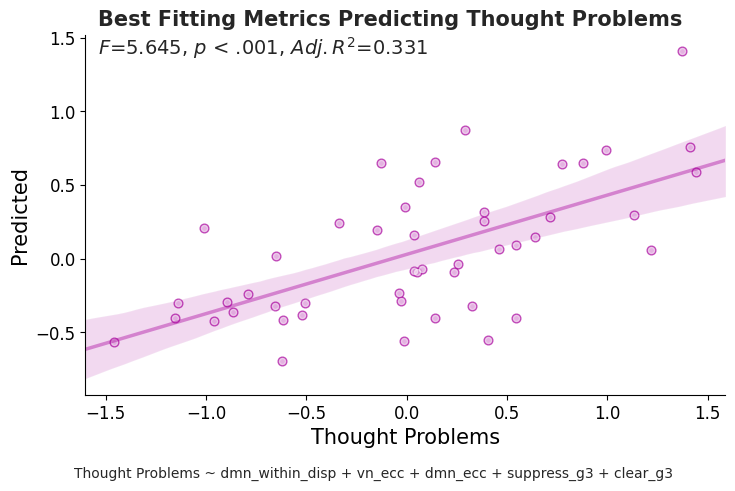

In [230]:
def reg_plots(data, x_vars, yvar, color, title, formula_title, save=None):

    import pandas as pd
    #import statsmodels.api as sm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set the entire script to use Arial
    plt.rcParams['font.family'] = 'sans-serif'
    
    joined_vars = ' + '.join(x_vars)
    new_y_vars = [joined_vars]
    formula = f'{yvar[0]} ~ {joined_vars}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Prepare the design matrix X with multiple x_vars
    #X = sm.add_constant(data[x_vars])  # Adding a constant
    #model = sm.OLS(data[yvar], X).fit()
    data['Predicted'] = model.predict()  # Store the predicted values

    # Adjust figure size
    fig, ax = plt.subplots(figsize=(8, 6))  # Increased figure size

    # Scatter plot with regression line, ensuring CI is shown
    sns.set_theme(style="white")

    # Scatter plot with regression line modifications
    sns.regplot(y='Predicted', x=f'{yvar[0]}', data=data, ci=95,
                color=color, scatter_kws={'s': 40, 'alpha': 0.6}, truncate=False, ax=ax,
                line_kws={'linewidth': 2.5, 'alpha': 0.4})  # Set line width and transparency

    sns.regplot(y='Predicted', x=f'{yvar[0]}', data=data, fit_reg=False,
                color='white', scatter_kws={'s': 20, 'alpha': .5}, truncate=False, ax=ax)


   # Set axis labels
    ax.set_xlabel('Thought Problems', fontsize=15)
    ax.set_ylabel('Predicted', fontsize=15)

    # Set title using text for precise control
    ax.text(.02, 1.07, title, transform=ax.transAxes, fontsize=15, fontweight='bold', verticalalignment='top')

    # Adding subtitle with F-statistic and p-value using text annotation, with 'p' in italic
    p_value_text = f"< .001" if model.f_pvalue < 0.001 else f"= {model.f_pvalue:.3f}"
    subtitle = f"$\it{{F}}$={model.fvalue:.3f}, $\it{{p}}$ {p_value_text}, $\it{{Adj. R}}^2$={model.rsquared_adj:.3f}"
    ax.text(0.02, 1, subtitle, transform=ax.transAxes, fontsize=14, verticalalignment='top')

    ax.tick_params(axis='both', labelsize=12)  # Increase tick label font size

    # Remove top and right borders
    sns.despine()

      # Formula at the bottom
    ax.text(0.45, -0.2, formula_title, transform=ax.transAxes, fontsize=10, ha='center', va='top')

    # Adjust tick parameters for both axes
    ax.tick_params(axis='both', labelsize=12)

    # Remove top and right borders
    sns.despine()

    # Manually adjust the subplot parameters
    plt.subplots_adjust(left=0.15, right=0.95, top=0.85, bottom=0.25)  # Adjusted to make space for formula text


    if save is not None:
        save_path = f'/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/operation_regressions/figures/{save}.png'
        plt.savefig(save_path, dpi=300,  bbox_inches='tight')

    plt.show()

# Formulas without 'thought_problems'
formulas = [
    'dmn_within_disp + vn_ecc + dmn_ecc + suppress_g3 + clear_g3',
    'dmn_within_disp + dmn_ecc + suppress_g3 + clear_g3',
    'dmn_within_disp + vn_ecc + dmn_ecc + total_acc',
    'dmn_within_disp + vn_ecc + dmn_ecc + total_acc + suppress_g3',
    'fpcn_within_disp + dmn_within_disp + dmn_ecc + suppress_g3 + clear_g3',
    'vn_dmn_across_disp + vn_ecc + dmn_ecc + suppress_g3 + clear_g3'
]

# Updated reg_formulas list
reg_formulas = [
    ['dmn_within_disp + vn_ecc + dmn_ecc + suppress_g3 + clear_g3'],
    ['dmn_within_disp + dmn_ecc + suppress_g3 + clear_g3'],
    ['dmn_within_disp + vn_ecc + dmn_ecc + total_acc'],
    ['dmn_within_disp + vn_ecc + dmn_ecc + total_acc + suppress_g3'],
    ['fpcn_within_disp + dmn_within_disp + dmn_ecc + suppress_g3 + clear_g3'],
    ['vn_dmn_across_disp + vn_ecc + dmn_ecc + suppress_g3 + clear_g3']
]

# Updated reg_vars list
reg_vars = [
    ['dmn_within_disp', 'vn_ecc', 'dmn_ecc', 'suppress_g3', 'clear_g3'],
    ['dmn_within_disp', 'dmn_ecc', 'suppress_g3', 'clear_g3'],
    ['dmn_within_disp', 'vn_ecc', 'dmn_ecc', 'total_acc'],
    ['dmn_within_disp', 'vn_ecc', 'dmn_ecc', 'total_acc', 'suppress_g3'],
    ['fpcn_within_disp', 'dmn_within_disp', 'dmn_ecc', 'suppress_g3', 'clear_g3'],
    ['vn_dmn_across_disp', 'vn_ecc', 'dmn_ecc', 'suppress_g3', 'clear_g3']
]


reg_plots(
    all_metrics_z_yeo, 
    reg_vars[0], 
    ['thought_problems'], 
    '#a8009d', 
    'Best Fitting Metrics Predicting Thought Problems', 
    f'Thought Problems ~ {reg_formulas[0][0]}', 
    save='top_formula')

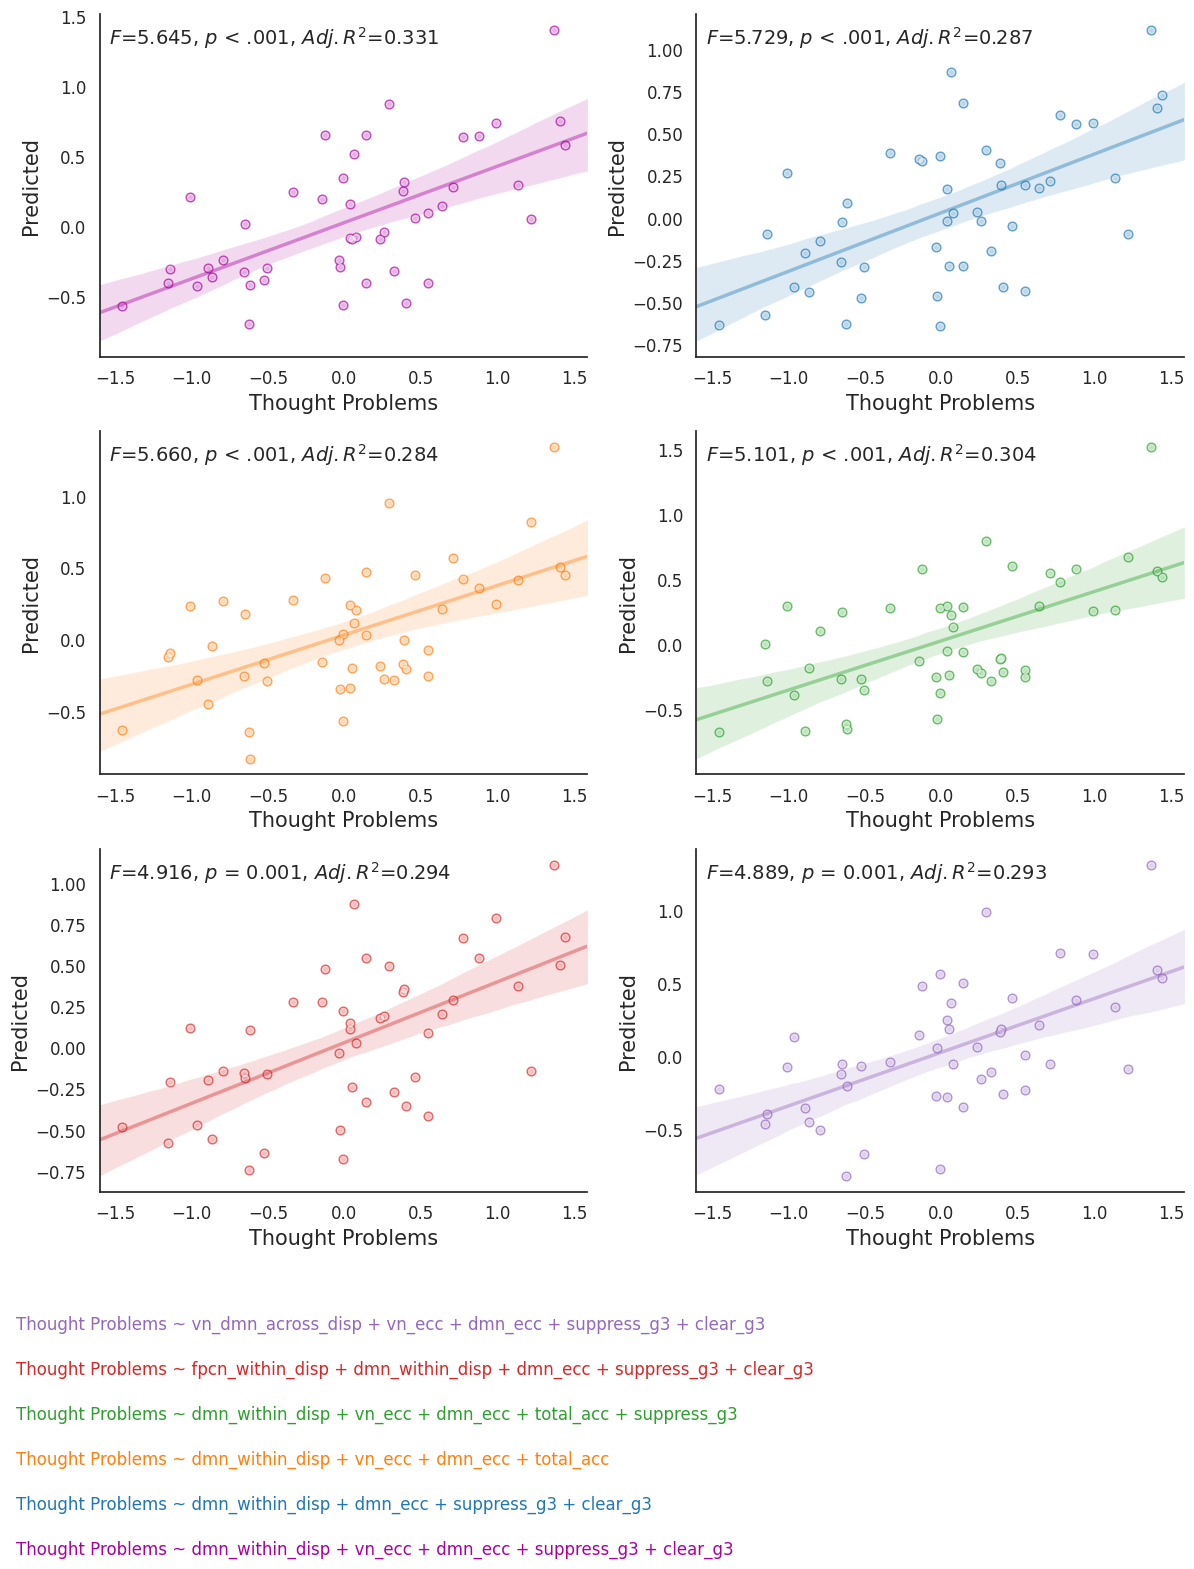

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

def reg_plots(data, x_vars, yvar, color, ax):
    joined_vars = ' + '.join(x_vars)
    formula = f'{yvar[0]} ~ {joined_vars}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Store the predicted values in the data
    data['Predicted'] = model.predict()

    # Scatter plot with regression line
    sns.set_theme(style="white")

    # Scatter plot with regression line modifications
    sns.regplot(y='Predicted', x=f'{yvar[0]}', data=data, ci=95,
                color=color, scatter_kws={'s': 40, 'alpha': 0.6}, truncate=False, ax=ax,
                line_kws={'linewidth': 2.5, 'alpha': 0.4})

    sns.regplot(y='Predicted', x=f'{yvar[0]}', data=data, fit_reg=False,
                color='white', scatter_kws={'s': 20, 'alpha': .5}, truncate=False, ax=ax)

    # Set axis labels
    ax.set_xlabel('Thought Problems', fontsize=15)
    ax.set_ylabel('Predicted', fontsize=15)

    # Adding subtitle with F-statistic and p-value using text annotation, with 'p' in italic
    p_value_text = f"< .001" if model.f_pvalue < 0.001 else f"= {model.f_pvalue:.3f}"
    subtitle = f"$\it{{F}}$={model.fvalue:.3f}, $\it{{p}}$ {p_value_text}, $\it{{Adj. R}}^2$={model.rsquared_adj:.3f}"
    ax.text(0.02, .97, subtitle, transform=ax.transAxes, fontsize=14, verticalalignment='top')

    ax.tick_params(axis='both', labelsize=12)  # Increase tick label font size

    # Remove top and right borders
    sns.despine()

# Formulas without 'thought_problems'
formulas = [
    'dmn_within_disp + vn_ecc + dmn_ecc + suppress_g3 + clear_g3',
    'dmn_within_disp + dmn_ecc + suppress_g3 + clear_g3',
    'dmn_within_disp + vn_ecc + dmn_ecc + total_acc',
    'dmn_within_disp + vn_ecc + dmn_ecc + total_acc + suppress_g3',
    'fpcn_within_disp + dmn_within_disp + dmn_ecc + suppress_g3 + clear_g3',
    'vn_dmn_across_disp + vn_ecc + dmn_ecc + suppress_g3 + clear_g3'
]

# Updated reg_formulas list
reg_formulas = [
    ['dmn_within_disp + vn_ecc + dmn_ecc + suppress_g3 + clear_g3'],
    ['dmn_within_disp + dmn_ecc + suppress_g3 + clear_g3'],
    ['dmn_within_disp + vn_ecc + dmn_ecc + total_acc'],
    ['dmn_within_disp + vn_ecc + dmn_ecc + total_acc + suppress_g3'],
    ['fpcn_within_disp + dmn_within_disp + dmn_ecc + suppress_g3 + clear_g3'],
    ['vn_dmn_across_disp + vn_ecc + dmn_ecc + suppress_g3 + clear_g3']
]

# Updated reg_vars list
reg_vars = [
    ['dmn_within_disp', 'vn_ecc', 'dmn_ecc', 'suppress_g3', 'clear_g3'],
    ['dmn_within_disp', 'dmn_ecc', 'suppress_g3', 'clear_g3'],
    ['dmn_within_disp', 'vn_ecc', 'dmn_ecc', 'total_acc'],
    ['dmn_within_disp', 'vn_ecc', 'dmn_ecc', 'total_acc', 'suppress_g3'],
    ['fpcn_within_disp', 'dmn_within_disp', 'dmn_ecc', 'suppress_g3', 'clear_g3'],
    ['vn_dmn_across_disp', 'vn_ecc', 'dmn_ecc', 'suppress_g3', 'clear_g3']
]

colors = ['#a8009d', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Add a single title at the top center
#fig.suptitle('Top Gradient Metrics Predicting Thought Problems', fontsize=18, fontweight='bold')

for i, ax in enumerate(axes.flatten()):
    if i < len(reg_formulas):
        reg_plots(
            all_metrics_z_yeo, 
            reg_vars[i], 
            ['thought_problems'], 
            colors[i], 
            ax
        )

# Add the formula titles at the bottom left of the figure
for i, formula in enumerate(reg_formulas):
    fig.text(0.01, -0.095 + (i * 0.03), f'Thought Problems ~ {formula[0]}', ha='left', fontsize=12, color=colors[i], va='bottom')

plt.tight_layout(rect=[-.01, 0.1, 1, 0.95])  # Adjust the layout to make space for the main title and formula text
plt.show()
